In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'Datasets/Synthetic_data_with_OEE_MME_16_06_24(in).csv'
data = pd.read_csv(file_path)

# Preprocess data (common steps)
data['Date'] = pd.to_datetime(data['Date'])
dates = data['Date']
data = data.drop(columns=['Date'])

# Feature scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data)

# Split data into training and testing sets
X = scaled_features
y = data[['MME', 'OEE']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
# Define the GRU model
def create_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(50, return_sequences=True)(inputs)
    x = GRU(50)(x)
    outputs = Dense(2)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Define the TCN model
def create_tcn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(2))
    model.compile(optimizer='adam', loss='mse')
    return model


In [3]:
# Reshape data for GRU and TCN models
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [4]:
# Train and evaluate the GRU model
gru_model = create_gru_model((X_train_reshaped.shape[1], 1))
gru_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2)
gru_predictions = gru_model.predict(X_test_reshaped)
gru_mse = mean_squared_error(y_test, gru_predictions)
gru_mae = mean_absolute_error(y_test, gru_predictions)

# Train and evaluate the TCN model
tcn_model = create_tcn_model((X_train_reshaped.shape[1], 1))
tcn_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2)
tcn_predictions = tcn_model.predict(X_test_reshaped)
tcn_mse = mean_squared_error(y_test, tcn_predictions)
tcn_mae = mean_absolute_error(y_test, tcn_predictions)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.8723 - val_loss: 0.3160
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1813 - val_loss: 0.1173
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0705 - val_loss: 0.0556
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0526 - val_loss: 0.0425
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0392 - val_loss: 0.0402
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0363 - val_loss: 0.0394
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0363 - val_loss: 0.0381
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0325 - val_loss: 0.0373
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0342 - val_loss: 0.0365
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0307 - val_loss: 0.0359
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0327 - val_loss: 0.0354
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

In [5]:
# Print the results
print(f'GRU MSE: {gru_mse}, MAE: {gru_mae}')
print(f'TCN MSE: {tcn_mse}, MAE: {tcn_mae}')

GRU MSE: 0.027217444467534935, MAE: 0.10263628704981372
TCN MSE: 0.02527713707529978, MAE: 0.1120104604851116


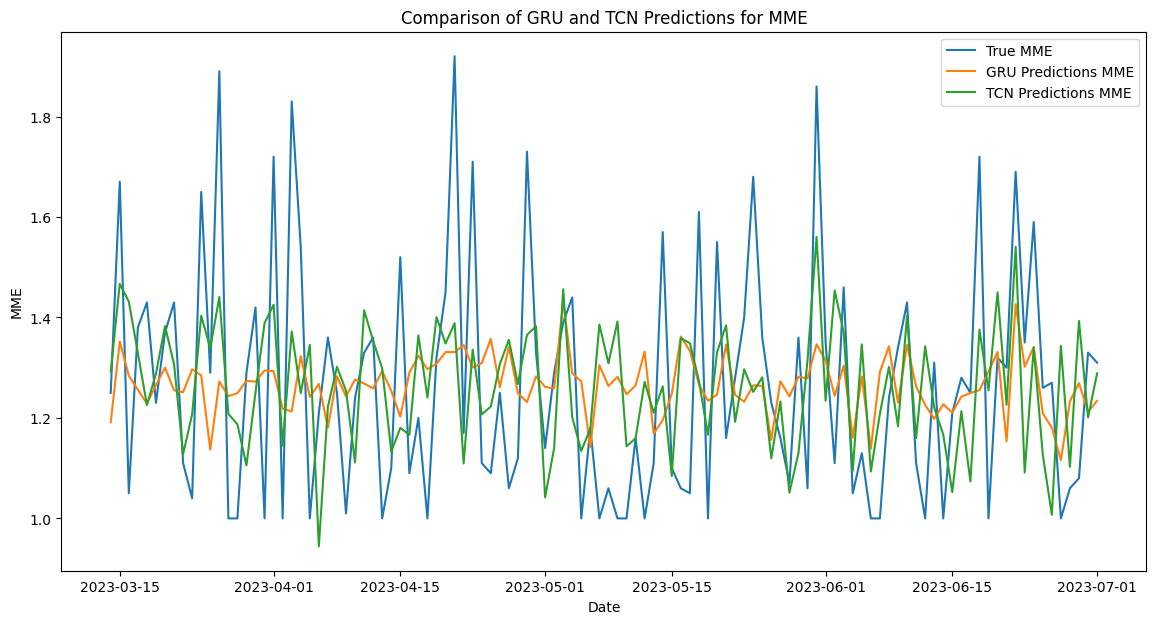

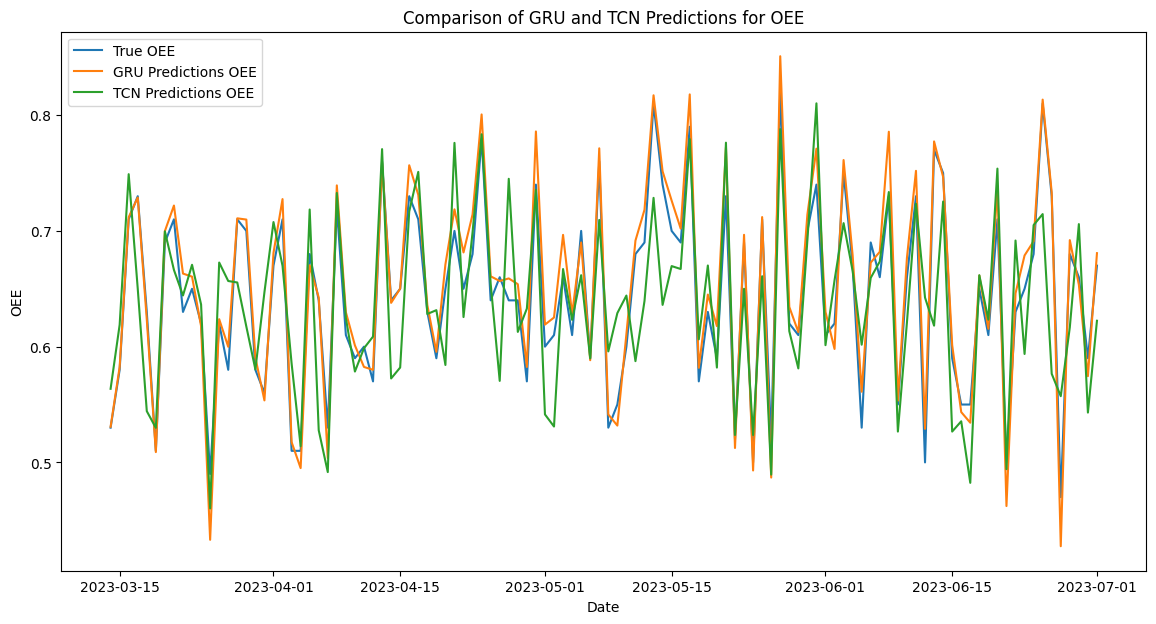

In [6]:
# Plot the results for MME
plt.figure(figsize=(14, 7))
plt.plot(dates[len(dates) - len(y_test):], y_test[:, 0], label='True MME')
plt.plot(dates[len(dates) - len(y_test):], gru_predictions[:, 0], label='GRU Predictions MME')
plt.plot(dates[len(dates) - len(y_test):], tcn_predictions[:, 0], label='TCN Predictions MME')
plt.title('Comparison of GRU and TCN Predictions for MME')
plt.xlabel('Date')
plt.ylabel('MME')
plt.legend()
plt.show()

# Plot the results for OEE
plt.figure(figsize=(14, 7))
plt.plot(dates[len(dates) - len(y_test):], y_test[:, 1], label='True OEE')
plt.plot(dates[len(dates) - len(y_test):], gru_predictions[:, 1], label='GRU Predictions OEE')
plt.plot(dates[len(dates) - len(y_test):], tcn_predictions[:, 1], label='TCN Predictions OEE')
plt.title('Comparison of GRU and TCN Predictions for OEE')
plt.xlabel('Date')
plt.ylabel('OEE')
plt.legend()
plt.show()